The following notebook contains the developments and experimentation of three of the main implementations, RL - AP - GCN , PonderNet-AP-GCN,and Gumbel-AP-GCN. 

In [ ]:
import torch
print(f"Current PyTorch version: {torch.__version__}")
print(f"Current CUDA version: {torch.version.cuda}")

!pip uninstall -y torch torchvision torchaudio
# PyTorch 2.5.0 with CUDA 12.4
!pip install torch==2.5.0+cu124 torchvision==0.20.0+cu124 torchaudio==2.5.0+cu124 --index-url https://download.pytorch.org/whl/cu124
#need ro restart session

#NOTICE THAT THIS LINE WAS DONE FOR VERSION COMPATIBILITY ISSUES IN GOOGLE COLAB WHEN THE PRE INSTALLED PYTORCH VERSION WAS NOT COMPATIBLE WITH THE AVAILABLE WHEELS FOR PYTORCH GEOMETRIC

Current PyTorch version: 2.6.0+cu124
Current CUDA version: 12.4
Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
Looking in indexes: https://download.pytorch.org/whl/cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 MB 748.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 88.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 71.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.1 MB/s

In [ ]:
!pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.5.0+cu124.html
!pip install torch-geometric
!pip install matplotlib seaborn PyYAML tqdm

Looking in links: https://data.pyg.org/whl/torch-2.5.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 80.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 68.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.0 MB/s eta 0:00:00
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
^C


# RL

In [ ]:
import os
import math
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.optim import Adam
import torch_geometric
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import degree, dropout_edge, add_self_loops
from torch_geometric.nn.conv.gcn_conv import gcn_norm
import torch_geometric.transforms as T
from torch.nn import ModuleList, Dropout, ReLU, Linear
from torch_geometric.nn import MessagePassing
from collections import deque
import seaborn as sns


# seeding
torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

RL model

Loading Cora dataset...
Dataset details:
  - Number of nodes: 2708
  - Number of edges: 10556
  - Number of features: 1433
  - Number of classes: 7
  - Number of training nodes: 140
  - Number of validation nodes: 500
  - Number of test nodes: 1000


/usr/local/lib/python3.11/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch 010 | Loss 2.7704 | Steps 6.27 | ValAcc 0.1220
Epoch 020 | Loss 2.4424 | Steps 6.39 | ValAcc 0.3240
Epoch 030 | Loss 2.0574 | Steps 5.96 | ValAcc 0.3420
Epoch 040 | Loss 2.1760 | Steps 5.94 | ValAcc 0.4780
Epoch 050 | Loss 1.8758 | Steps 5.79 | ValAcc 0.5480
Epoch 060 | Loss 1.8792 | Steps 5.96 | ValAcc 0.6420
Epoch 070 | Loss 2.0180 | Steps 5.55 | ValAcc 0.7180
Epoch 080 | Loss 1.7570 | Steps 6.04 | ValAcc 0.6180
Epoch 090 | Loss 1.8376 | Steps 6.27 | ValAcc 0.7440
Epoch 100 | Loss 1.7329 | Steps 5.46 | ValAcc 0.6720
Epoch 110 | Loss 1.7864 | Steps 5.64 | ValAcc 0.7600
Epoch 120 | Loss 1.6265 | Steps 5.86 | ValAcc 0.7480
Epoch 130 | Loss 1.6768 | Steps 5.63 | ValAcc 0.7400
Epoch 140 | Loss 1.5827 | Steps 5.52 | ValAcc 0.7500
Epoch 150 | Loss 1.6337 | Steps 5.54 | ValAcc 0.7480
Epoch 160 | Loss 1.5839 | Steps 4.96 | ValAcc 0.7780
Epoch 170 | Loss 1.6638 | Steps 5.69 | ValAcc 0.7380
Epoch 180 | Loss 1.5691 | Steps 5.42 | ValAcc 0.7980
Epoch 190 | Loss 1.5571 | Steps 5.49 | ValAcc 

<ipython-input-9-54a37b1d279a>:409: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_acc_model_path))


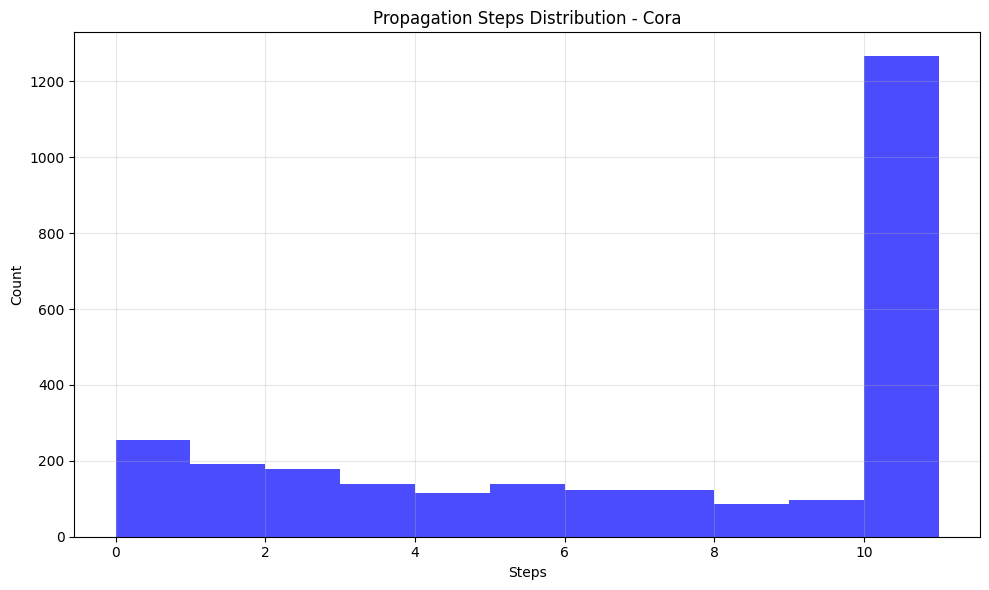

Steps statistics:
  Average: 6.61 ± 3.81
  Min: 0.00, Max: 10.00


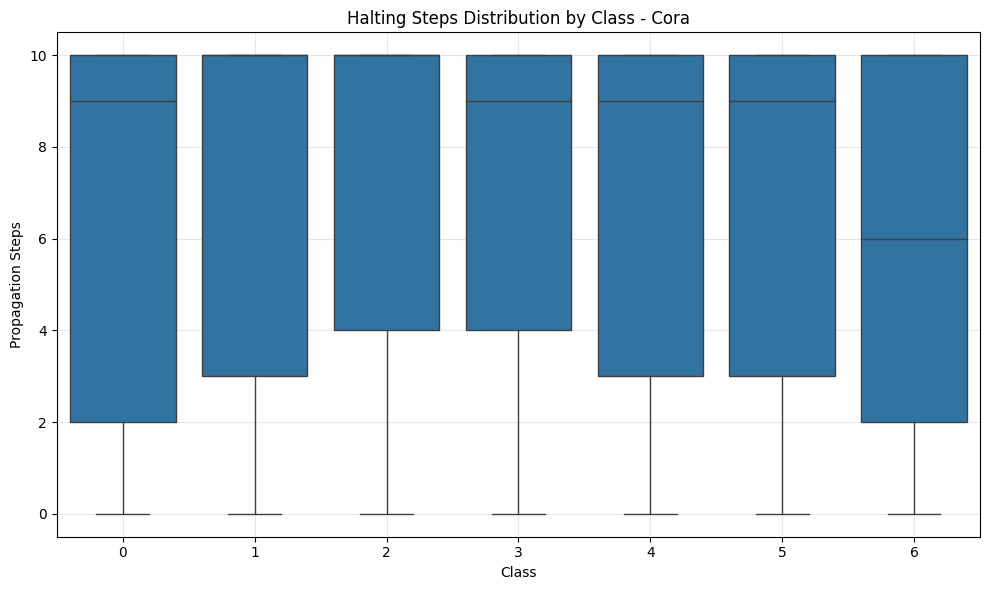

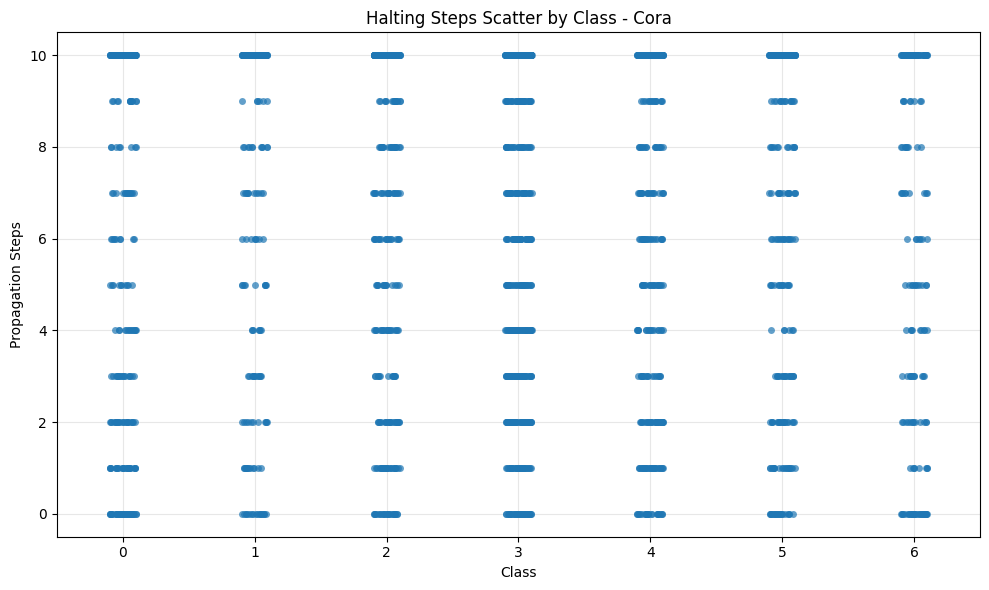

In [ ]:
class RewardNormalizer:
    def __init__(self, size=100):
        self.returns = deque(maxlen=size)

    def normalize(self, reward):
        self.returns.append(reward)
        if len(self.returns) > 1:
            mean = np.mean(self.returns)
            std = np.std(self.returns) + 1e-8
            return (reward - mean) / std
        return reward


class RLAdaptiveProp(MessagePassing):
    def __init__(self,
                 niter: int,
                 h_size: int,
                 computation_penalty=0,
                 exploration_factor=0.1,
                 use_scheduled_penalty=True,
                 **kwargs):
        """
        Args:
          niter: maximum number of propagation steps
          h_size: size of the node embeddings for policy & value networks
          computation_penalty: base penalty for each propagation step
          exploration_factor: controls exploration noise
          use_scheduled_penalty: if we want to phase in the penalty over epochs -> we actually dont use it but was a first appraoch to add it.
        """
        super(RLAdaptiveProp, self).__init__(aggr='add', **kwargs)
        self.niter = niter
        self.base_computation_penalty = computation_penalty
        self.computation_penalty = computation_penalty
        self.exploration_factor = exploration_factor
        self.use_scheduled_penalty = use_scheduled_penalty

        self.current_epoch = 0
        self.total_epochs = 1000  #i hardcode this, need to change

        # POLICY NETWORK HERE: MANAGE THE HALTING DECISION.
        self.policy_hidden1 = Linear(h_size, h_size // 2)
        self.policy_hidden2 = Linear(h_size // 2, h_size // 4)
        self.policy = Linear(h_size // 4, 1)

        # VALUE NETWORK FOR THE BASELINE.
        self.value_hidden1 = Linear(h_size, h_size // 2)
        self.value_hidden2 = Linear(h_size // 2, h_size // 4)
        self.value = Linear(h_size // 4, 1)

        self.reg_params = list(self.policy_hidden1.parameters()) + \
                          list(self.policy_hidden2.parameters()) + \
                          list(self.policy.parameters())
        self.dropout = Dropout()

        self.improved = False
        self.add_self_loops = True

        self.reset_parameters()

    def set_epoch(self, current, total):
        self.current_epoch = current
        self.total_epochs = total
        if self.use_scheduled_penalty:
            self.update_computation_penalty()

    def update_computation_penalty(self):
        """
          my first idea was to think of the task as 3 phases.  a first part we allow to go to more layers by lower penalty
          and slowly goes up such that enforce lower layers later on , once the layers are more or less trained. anyway, 
          since the computation penalty is set to 0, we could just remove it.
        """
        progress = self.current_epoch / max(self.total_epochs, 1)
        if progress < 0.3:
            self.computation_penalty = self.base_computation_penalty * 0.1
        elif progress < 0.7:
            phase_progress = (progress - 0.3) / 0.4
            self.computation_penalty = self.base_computation_penalty * (0.1 + 0.9 * phase_progress)
        else:
            self.computation_penalty = self.base_computation_penalty

    def reset_parameters(self):
        self.policy_hidden1.reset_parameters()
        self.policy_hidden2.reset_parameters()
        self.policy.reset_parameters()
        self.value_hidden1.reset_parameters()
        self.value_hidden2.reset_parameters()
        self.value.reset_parameters()
        # policy bias to -2.5 . lower sets prob of halting lower  which encourage deeper propagation -> can estimate by sigmoid introducing
        # WE COULD THINK THIS AS AN HYPERPARAMETER THOUGH! ALTHOUGH THE APGCN AUTHORS DO SOMETHING SIMILAR WITH 1/N
        if hasattr(self.policy, 'bias') and self.policy.bias is not None:
            self.policy.bias.data.fill_(-2.5)

    def forward(self, local_preds: torch.FloatTensor, edge_index):
        sz = local_preds.size(0)
        x = local_preds.clone()
        steps = torch.zeros(sz, device=local_preds.device) #count on zeros!
        active = torch.ones(sz, dtype=torch.bool, device=local_preds.device) #all need to start active -> 1

        #record per node:  the log probability, value and entropy at halting
        halting_log_prob = torch.zeros(sz, device=local_preds.device)
        halting_value = torch.zeros(sz, device=local_preds.device)
        halting_entropy = torch.zeros(sz, device=local_preds.device)

        prop = self.dropout(local_preds)

        # exploration noise (decays over epochs)
        current_exploration = self.exploration_factor
        if self.total_epochs > 0:
            decay_rate = 3.0 #WE NEED TO PASS ALSO AS HYPERPARAMETER ALTHOUGH NOT A BIG THING
            progress = self.current_epoch / self.total_epochs
            current_exploration = self.exploration_factor * math.exp(-decay_rate * progress)

        # here is where mp occurs
        for t in range(self.niter):
            if not active.any():
                break

            # dropout and normalization as authors did for more clear comparison.
            drop_edge_index, _ = dropout_edge(edge_index, p=0.5, training=self.training)
            edge_index_norm, norm = gcn_norm(
                drop_edge_index, None, sz, self.improved,
                self.add_self_loops, self.flow, local_preds.dtype
            )

            new_prop = self.propagate(edge_index_norm, x=prop, norm=norm)
            prop = torch.where(active.unsqueeze(1), new_prop, prop) #prop only for active nodes
            x = prop

            # policy (halting probability) and value for all nodes
            p_hidden = F.relu(self.policy_hidden1(x))
            p_hidden = F.relu(self.policy_hidden2(p_hidden))
            halt_logits = self.policy(p_hidden).view(-1)
            p = torch.sigmoid(halt_logits)

            v_hidden = F.relu(self.value_hidden1(x))
            v_hidden = F.relu(self.value_hidden2(v_hidden))
            v = self.value(v_hidden).view(-1)

            entropy = -(p * torch.log(p + 1e-10) + (1 - p) * torch.log(1 - p + 1e-10)) #entropy of the policy to encorage different halting and check out
            noise = torch.randn_like(p) * current_exploration # the idea of adding noise was to also encorage different ranges of certainty.
            noisy_p = torch.clamp(p + noise, 0.01, 0.99)
            u = torch.rand_like(noisy_p)
            action = (u < noisy_p)
            halt = active & action # the ones that halt!

            # for those who halts then:
            if halt.any():
                halting_log_prob[halt] = torch.log(noisy_p[halt] + 1e-10)
                halting_value[halt] = v[halt]
                halting_entropy[halt] = entropy[halt]

            active = active & (~halt)
            steps[active] = t + 1

        # last case in case no halt
        if active.any():
            halting_log_prob[active] = torch.log(noisy_p[active] + 1e-10)
            halting_value[active] = v[active]
            halting_entropy[active] = entropy[active]
            steps[active] = self.niter

        policy_state = {
            'halting_log_prob': halting_log_prob,  # [num_nodes]
            'halting_value': halting_value,
            'halting_entropy': halting_entropy
        }
        return x, steps, policy_state

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

class RL_AP_GCN(torch.nn.Module):
    def __init__(self,
                 dataset,
                 niter=10,
                 computation_penalty= 0.0, # 0.0005,
                 exploration_factor=0.1,
                 use_scheduled_penalty=True,
                 hidden=[64],
                 dropout=0.5):
        super(RL_AP_GCN, self).__init__()
        num_features = [dataset.data.x.shape[1]] + hidden + [dataset.num_classes]
        layers = []
        for in_features, out_features in zip(num_features[:-1], num_features[1:]):
            layers.append(Linear(in_features, out_features))
        self.prop = RLAdaptiveProp(
            niter=niter,
            h_size=dataset.num_classes,
            computation_penalty=computation_penalty,
            exploration_factor=exploration_factor,
            use_scheduled_penalty=use_scheduled_penalty
        )
        self.layers = ModuleList(layers)
        self.reg_params = list(layers[0].parameters())
        self.non_reg_params = [p for l in layers[1:] for p in l.parameters()] + list(self.prop.parameters())
        self.dropout = Dropout(p=dropout)
        self.act_fn = ReLU()
        self.reset_parameters()

    def reset_parameters(self):
        self.prop.reset_parameters()
        for layer in self.layers:
            layer.reset_parameters()

    def set_epoch(self, current, total):
        self.prop.set_epoch(current, total)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        for i, layer in enumerate(self.layers):
            x = layer(self.dropout(x))
            if i < len(self.layers) - 1:
                x = self.act_fn(x)
        x, steps, policy_state = self.prop(x, edge_index)
        return F.log_softmax(x, dim=1), steps, policy_state

def train(model, data, optimizer, normalizer, epoch, total_epochs,
                      weight_decay=0.008, entropy_weight=0.01, value_weight=0.5,
                      max_grad_norm=1.0):
    model.train()
    model.set_epoch(epoch, total_epochs)
    optimizer.zero_grad()

    logits, steps, policy_state = model(data)
    task_loss = F.nll_loss(logits[data.train_mask], data.y[data.train_mask])
    l2_reg = sum(torch.sum(param ** 2) for param in model.reg_params)
    supervised_loss = task_loss + weight_decay * 0.5 * l2_reg

    # RL part
    train_mask = data.train_mask
    pred = logits.argmax(dim=1)
    correctness = (pred == data.y).float()  # 1 if correct, 0 otherwise
    current_penalty = model.prop.computation_penalty
    node_steps = steps  # shape: [num_nodes]
    reward = correctness - current_penalty * node_steps  # per-node reward -> THIS CAN BE EVEN COMMENTED OUT BUT ANYWAY I SET IT TO 0.

    halting_value = policy_state['halting_value']
    advantage = reward - halting_value  # per-node advantage

    mask_idx = train_mask.nonzero(as_tuple=True)[0]
    halting_log_prob = policy_state['halting_log_prob']
    policy_loss = - (halting_log_prob[mask_idx] * advantage[mask_idx].detach()).mean()
    value_loss = F.mse_loss(halting_value[mask_idx], reward[mask_idx])
    halting_entropy = policy_state['halting_entropy']
    entropy_loss = - halting_entropy[mask_idx].mean() * entropy_weight

    rl_loss = policy_loss + value_weight * value_loss + entropy_loss
    total_loss = supervised_loss + rl_loss

    total_loss.backward()
    if max_grad_norm > 0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
    optimizer.step()
    return total_loss.item(), steps[train_mask].mean().item()


def evaluate(model, data, mask=None):
    model.eval()
    with torch.no_grad():
        logits, steps, _ = model(data)
        if mask is None:
            mask = torch.ones(data.num_nodes, dtype=torch.bool, device=data.x.device)
        pred = logits[mask].max(1)[1]
        correct = pred.eq(data.y[mask]).sum().item()
        total = mask.sum().item()
        acc = correct / total if total > 0 else 0
        avg_steps = steps[mask].mean().item() if total > 0 else 0

    return acc, avg_steps

### VISUALIZATION PART:
def visualize_enhanced_rl_results(model, data, dataset_name, save_dir='./visualizations'):
    os.makedirs(save_dir, exist_ok=True)
    model.eval()
    with torch.no_grad():
        _, steps, _ = model(data)
        steps_np = steps.cpu().numpy()


        labels = data.y.cpu().numpy()
        unique_labels = np.unique(labels)
        for label in unique_labels:
            node_steps = steps_np[labels == label]
            print(f"Class {label}: Mean steps = {node_steps.mean():.2f}, Std = {node_steps.std():.2f}")
    plt.figure(figsize=(10, 6))
    plt.hist(steps_np, bins=range(0, model.prop.niter+2), alpha=0.7, color='blue')
    plt.title(f'Propagation Steps Distribution - {dataset_name}')
    plt.xlabel('Steps')
    plt.ylabel('Count')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f'enhanced_rl_steps_{dataset_name}.png'), dpi=300)
    plt.show()
    print("Steps statistics:")
    print(f"  Average: {steps_np.mean():.2f} ± {steps_np.std():.2f}")
    print(f"  Min: {steps_np.min():.2f}, Max: {steps_np.max():.2f}")

def visualize_halting_by_class(model, data, dataset_name, save_dir='./visualizations'):
    """
    distribution of halting steps for each node grouped by class.
    """
    os.makedirs(save_dir, exist_ok=True)
    model.eval()
    with torch.no_grad():
        _, steps, _ = model(data)
        steps_np = steps.cpu().numpy()
        labels = data.y.cpu().numpy()

    # Boxplot of steps by class
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=labels, y=steps_np)
    plt.title(f'Halting Steps Distribution by Class - {dataset_name}')
    plt.xlabel('Class')
    plt.ylabel('Propagation Steps')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f'halting_by_class_box_{dataset_name}.png'), dpi=300)
    plt.show()

    # Scatter plot: each node's halting step vs. its class
    plt.figure(figsize=(10, 6))
    sns.stripplot(x=labels, y=steps_np, jitter=True, alpha=0.7)
    plt.title(f'Halting Steps Scatter by Class - {dataset_name}')
    plt.xlabel('Class')
    plt.ylabel('Propagation Steps')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f'halting_by_class_scatter_{dataset_name}.png'), dpi=300)
    plt.show()

### DB AND HYPERPARAMS
def load_dataset(dataset_name="Cora"):
    print(f"Loading {dataset_name} dataset...")
    dataset = Planetoid(root=f'./data/{dataset_name}', name=dataset_name, transform=T.NormalizeFeatures())
    data = dataset[0].to(device)
    print(f"Dataset details:")
    print(f"  - Number of nodes: {data.num_nodes}")
    print(f"  - Number of edges: {data.num_edges}")
    print(f"  - Number of features: {data.num_features}")
    print(f"  - Number of classes: {dataset.num_classes}")
    print(f"  - Number of training nodes: {data.train_mask.sum().item()}")
    print(f"  - Number of validation nodes: {data.val_mask.sum().item()}")
    print(f"  - Number of test nodes: {data.test_mask.sum().item()}")
    return dataset, data

def get_hyperparameters(dataset_name):
    params = {
        'hidden': [64],
        'dropout': 0.5,
        'niter': 10,
        'learning_rate': 0.01,
        'weight_decay': 0.008
    }
    if dataset_name == "Cora":
        params['computation_penalty'] = 0.0 # 0.0005
    elif dataset_name == "Citeseer":
        params['computation_penalty'] = 0.0 # 0.0002
    elif dataset_name == "PubMed":
        params['computation_penalty'] = 0.0 # 0.0002
    else:
        params['computation_penalty'] = 0.0 #. 0.0005
    return params

def trainer(dataset, data, hyperparams, epochs=500, patience=50,
                            exploration_factor=0.2, entropy_weight=0.01,
                            value_weight=0.5, max_grad_norm=1.0):
    best_val_acc = -1.0
    counter = 0
    best_acc_model_path = f"best_acc_model_{dataset.name}.pt"
    best_model_path = f"best_model_{dataset.name}.pt"

    model = RL_AP_GCN(
        dataset=dataset,
        niter=hyperparams['niter'],
        computation_penalty=hyperparams['computation_penalty'],
        exploration_factor=exploration_factor,
        use_scheduled_penalty=True,
        hidden=hyperparams['hidden'],
        dropout=hyperparams['dropout']
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=hyperparams['learning_rate'])
    normalizer = RewardNormalizer()

    for epoch in range(1, epochs + 1):
        train_loss, train_step = train(
            model, data, optimizer, normalizer, epoch, epochs,
            weight_decay=hyperparams['weight_decay'],
            entropy_weight=entropy_weight,
            value_weight=value_weight,
            max_grad_norm=max_grad_norm
        )
        val_acc, val_step = evaluate(model, data, data.val_mask)
        efficiency_factor = 1.0 - (val_step / max(1, model.prop.niter))

        if val_acc >= best_val_acc:
            best_val_acc = val_acc
            counter = 0
            torch.save(model.state_dict(), best_acc_model_path)
        else:
            counter += 1

        if counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        if epoch % 10 == 0:
            print(f"Epoch {epoch:03d} | Loss {train_loss:.4f} | Steps {train_step:.2f} | ValAcc {val_acc:.4f}")

    print("\nTesting with different saved models:")
    model.load_state_dict(torch.load(best_acc_model_path))
    test_acc, test_step = evaluate(model, data, data.test_mask)
    print(f"Best accuracy model - Test Acc: {test_acc:.4f}, Avg Steps: {test_step:.2f}")

    return model

def main(dataset_name="Cora", epochs=500, patience=50,
                     exploration_factor=0.02, entropy_weight=0.01,
                     value_weight=0.5, max_grad_norm=1.0):
    dataset, data = load_dataset(dataset_name)
    hyperparams = get_hyperparameters(dataset_name)
    model = trainer(
        dataset, data, hyperparams, epochs=epochs, patience=patience,
        exploration_factor=exploration_factor, entropy_weight=entropy_weight,
        value_weight=value_weight, max_grad_norm=max_grad_norm
    )
    visualize_enhanced_rl_results(model, data, dataset_name)
    visualize_halting_by_class(model, data, dataset_name)
    return model, data

if __name__ == "__main__":
    model, data = main(
        dataset_name="Cora",
        epochs=2000,
        patience=500,
        exploration_factor=0.01,
        entropy_weight=0.01,
        value_weight=0.5,
        max_grad_norm=1.0,
    )


# Ponder Net


Using device: cpu
Loading Cora dataset...
Running grid search...

Trying lambda_p=0.1, beta=0.01


/usr/local/lib/python3.11/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch: 010, Loss: 1.9545 (Rec: 1.9244, KL: 0.9744), Steps: 2.08, Val Acc: 0.1360, Val Steps: 3.64
Epoch: 020, Loss: 1.9348 (Rec: 1.8922, KL: 0.8827), Steps: 2.25, Val Acc: 0.2760, Val Steps: 3.50
Epoch: 030, Loss: 1.9113 (Rec: 1.8403, KL: 0.8024), Steps: 2.42, Val Acc: 0.3800, Val Steps: 3.71
Epoch: 040, Loss: 1.8277 (Rec: 1.7084, KL: 0.7082), Steps: 2.65, Val Acc: 0.5180, Val Steps: 3.98
Epoch: 050, Loss: 1.8109 (Rec: 1.6369, KL: 0.6116), Steps: 2.96, Val Acc: 0.5700, Val Steps: 4.11
Epoch: 060, Loss: 1.7039 (Rec: 1.4687, KL: 0.5855), Steps: 3.19, Val Acc: 0.7540, Val Steps: 3.95
Epoch: 070, Loss: 1.6445 (Rec: 1.3558, KL: 0.5376), Steps: 3.68, Val Acc: 0.7640, Val Steps: 4.06
Epoch: 080, Loss: 1.6044 (Rec: 1.2868, KL: 0.4931), Steps: 4.22, Val Acc: 0.7600, Val Steps: 3.91
Epoch: 090, Loss: 1.5134 (Rec: 1.1753, KL: 0.6610), Steps: 3.73, Val Acc: 0.7560, Val Steps: 4.04
Epoch: 100, Loss: 1.4098 (Rec: 1.0532, KL: 0.6041), Steps: 4.38, Val Acc: 0.7600, Val Steps: 4.16
Epoch: 110, Loss: 1.

<ipython-input-30-9ddedba190e1>:329: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_model_{config['dataset_name']}.pt"))


Epoch: 010, Loss: 1.9602 (Rec: 1.9220, KL: 0.9010), Steps: 2.21, Val Acc: 0.1620, Val Steps: 3.69
Epoch: 020, Loss: 1.9386 (Rec: 1.8852, KL: 0.8650), Steps: 2.28, Val Acc: 0.3100, Val Steps: 3.71
Epoch: 030, Loss: 1.8997 (Rec: 1.8114, KL: 0.7488), Steps: 2.54, Val Acc: 0.4220, Val Steps: 3.69
Epoch: 040, Loss: 1.8525 (Rec: 1.7167, KL: 0.6632), Steps: 2.77, Val Acc: 0.5820, Val Steps: 3.85
Epoch: 050, Loss: 1.7834 (Rec: 1.5883, KL: 0.5901), Steps: 3.04, Val Acc: 0.5820, Val Steps: 4.01
Epoch: 060, Loss: 1.6984 (Rec: 1.4478, KL: 0.5545), Steps: 3.34, Val Acc: 0.6540, Val Steps: 4.02
Epoch: 070, Loss: 1.6612 (Rec: 1.3657, KL: 0.6462), Steps: 3.21, Val Acc: 0.7200, Val Steps: 3.89
Epoch: 080, Loss: 1.5429 (Rec: 1.2162, KL: 0.5944), Steps: 4.26, Val Acc: 0.7460, Val Steps: 3.80
Epoch: 090, Loss: 1.4775 (Rec: 1.1193, KL: 0.6841), Steps: 4.30, Val Acc: 0.7780, Val Steps: 4.10
Epoch: 100, Loss: 1.4529 (Rec: 1.0802, KL: 0.7858), Steps: 4.62, Val Acc: 0.7500, Val Steps: 4.33
Epoch: 110, Loss: 1.

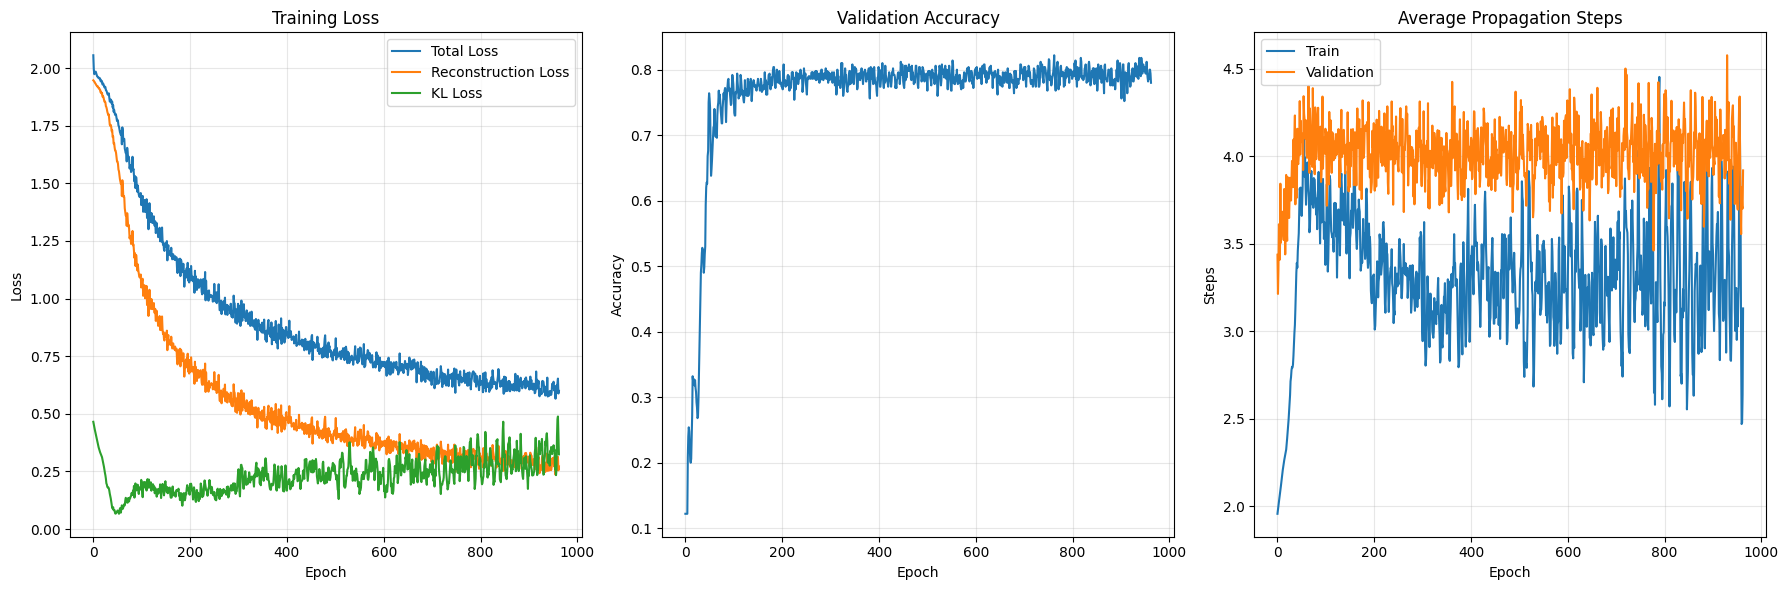

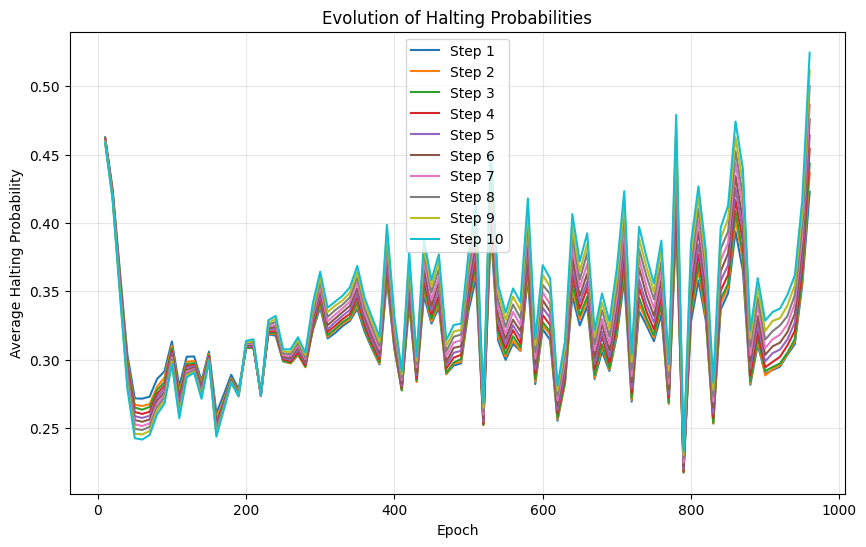

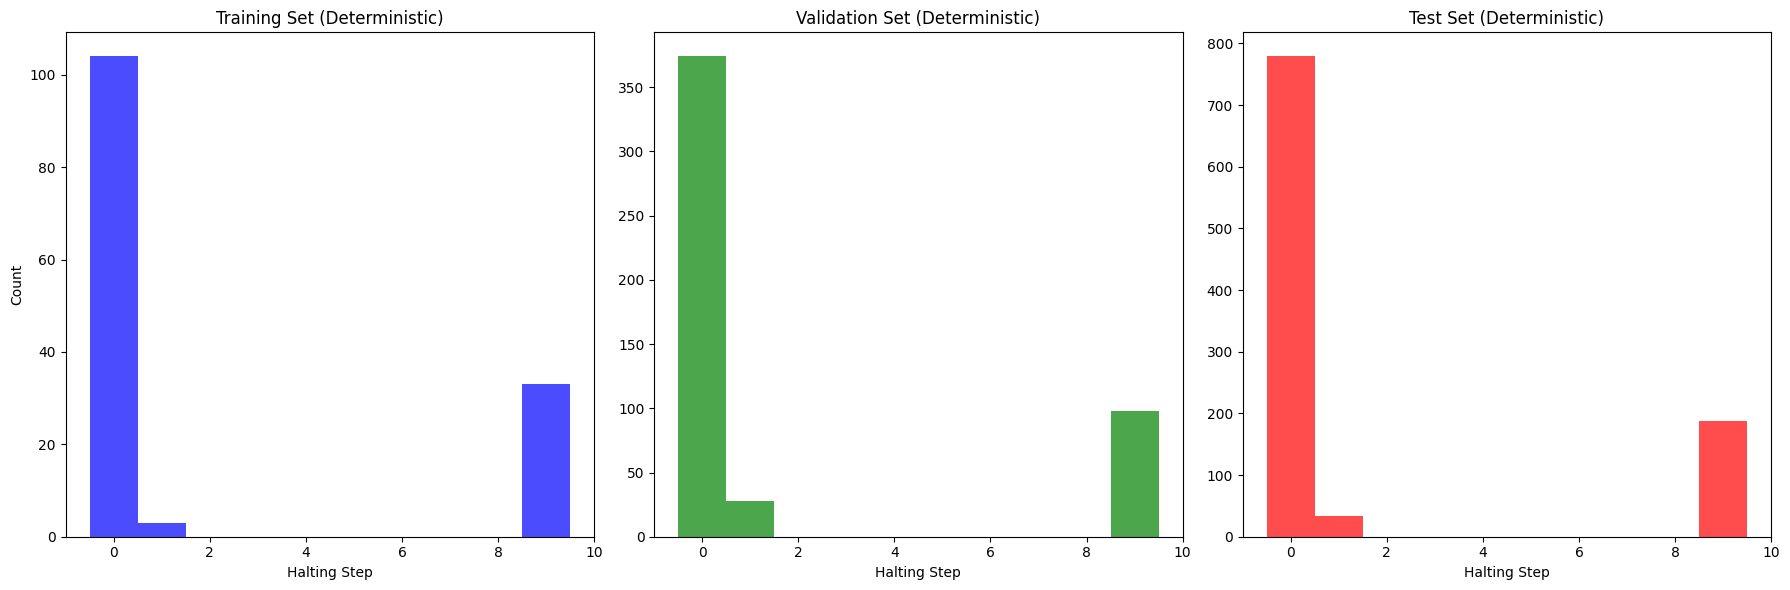

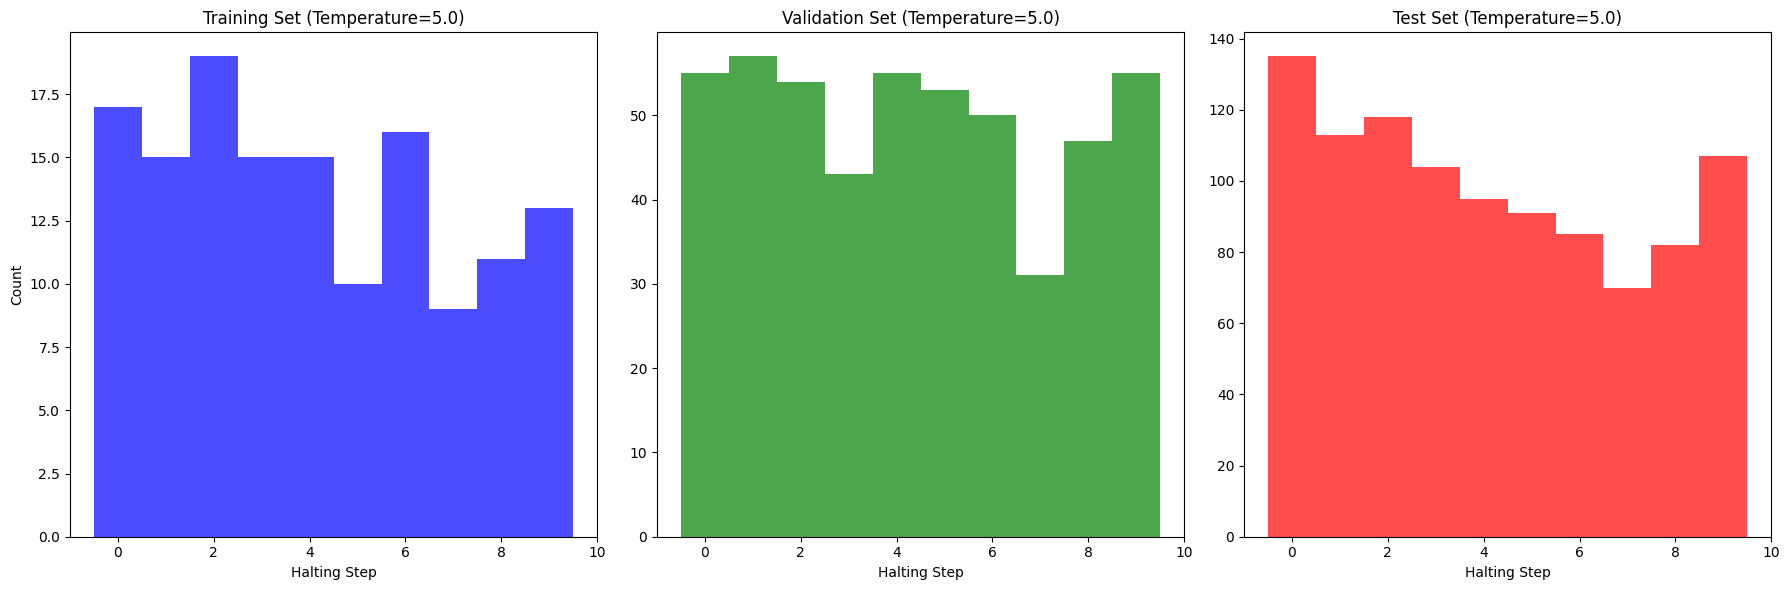

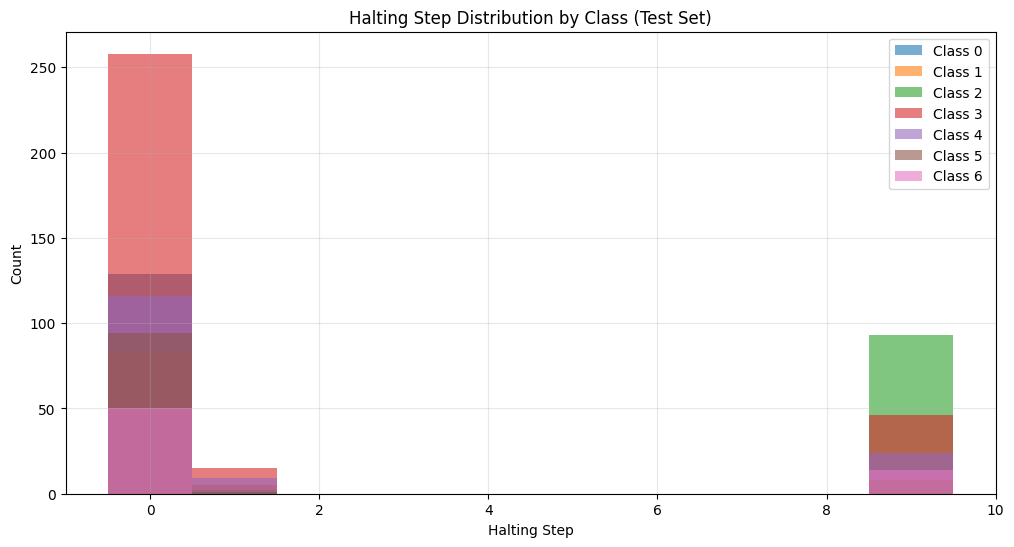

Evaluating impact of inference temperature...
Temperature: 0.10, Accuracy: 0.8140, Avg Steps: 1.77
Temperature: 0.25, Accuracy: 0.8060, Avg Steps: 1.74
Temperature: 0.50, Accuracy: 0.8220, Avg Steps: 2.11
Temperature: 0.75, Accuracy: 0.8190, Avg Steps: 2.35
Temperature: 1.00, Accuracy: 0.8200, Avg Steps: 2.86
Temperature: 2.00, Accuracy: 0.8240, Avg Steps: 3.55
Temperature: 5.00, Accuracy: 0.8270, Avg Steps: 4.18


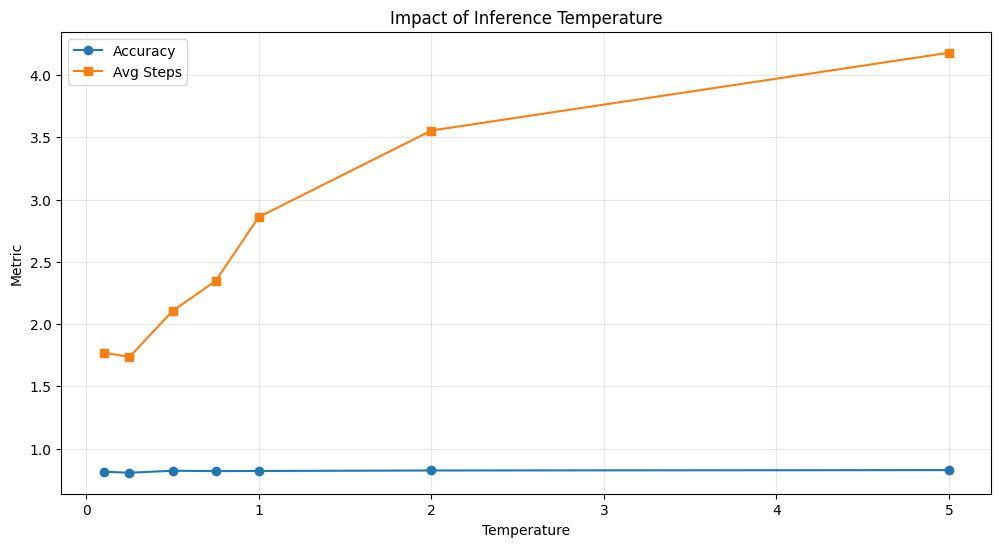

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch.nn import ModuleList, Dropout, ReLU, Linear
from torch_geometric.nn import MessagePassing
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import dropout_edge
from torch_geometric.nn.conv.gcn_conv import gcn_norm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time

# seeding:
torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

## Hyperparams
config = {
    "dataset_name": "Cora",
    "mlp_hidden": [64],            #readout size mlp
    "dropout": 0.5,

    "niter": 10,
    "edge_dropout": 0.3,

    # Ponder settings
    "beta": 0.05,                  # Weight for KL divergence
    "lambda_p": 0.2,               # prior halting probability

    "halt_bias_init": 0.0,


    "learning_rate": 0.01,
    "weight_decay": 0.008,
    "num_epochs": 1000,
    "patience": 200,

    # Inference settings
    "inference_temperature": 5.0   # Temperature for sampling during inference (lower = more deterministic)
}


class APGCN_Ponder(nn.Module):
    def __init__(self, dataset, config):
        """
        AP-GCN with PonderNet-style halting
        """
        super(APGCN_Ponder, self).__init__()

        self.config = config
        self.niter = config["niter"]

        # Local prediction network (MLP)
        num_features = [dataset.data.x.shape[1]] + config["mlp_hidden"] + [dataset.num_classes]
        #we pass the number of features of node + dimensions of the mlp + output dim
        self.layers = ModuleList()

        for i in range(len(num_features) - 1):
            self.layers.append(Linear(num_features[i], num_features[i+1]))

        self.halt = Linear(dataset.num_classes, 1) # halting unit
        if config["halt_bias_init"] is not None:
            self.halt.bias.data.fill_(config["halt_bias_init"])


        self.reg_params = list(self.layers[0].parameters()) # L2 regularization parameters on first layer like authors of apgcn

        self.dropout = Dropout(p=config["dropout"])
        self.act_fn = ReLU()

        # KL regularization settings
        self.beta = config["beta"]
        self.lambda_p = config["lambda_p"]

    def forward(self, data, edge_dropout=None):
        x, edge_index = data.x, data.edge_index

        if edge_dropout is None:
            edge_dropout = self.config["edge_dropout"]

        # local prediction network
        h = x
        for i, layer in enumerate(self.layers):
            h = layer(self.dropout(h))
            if i < len(self.layers) - 1:
                h = self.act_fn(h)

        # storage of those outputs
        outputs = [h]

        # Propagation loop
        prop_h = h
        halting_logits = []

        for _ in range(self.niter):
            if self.training and edge_dropout > 0:
                drop_edge_index, _ = dropout_edge(edge_index, p=edge_dropout)
            else:
                drop_edge_index = edge_index

            edge_index_norm, norm = gcn_norm(
                drop_edge_index, None,
                x.size(0), False, True, "source_to_target", x.dtype
            )

            #mp
            prop_h = self.propagate(edge_index_norm, x=prop_h, norm=norm)
            outputs.append(prop_h)

            #halting logits
            logit = self.halt(prop_h)
            logit = torch.clamp(logit, min=-10, max=10)
            halting_logits.append(logit)

        halting_logits = torch.cat(halting_logits, dim=1)
        lambda_vals = torch.sigmoid(halting_logits)
        # halting distribution (p_n from PonderNet paper)
        p_list = []
        cumulative_remain_prob = torch.ones(lambda_vals.size(0), 1, device=lambda_vals.device)
        for n in range(self.niter):
            p_n = lambda_vals[:, n:n+1] * cumulative_remain_prob
            p_list.append(p_n)
            cumulative_remain_prob = cumulative_remain_prob * (1 - lambda_vals[:, n:n+1])

        # remaining probability
        p_list[-1] = p_list[-1] + cumulative_remain_prob

        # halting probabilities
        p = torch.cat(p_list, dim=1)

        return outputs, p, halting_logits

    def propagate(self, edge_index, x, norm):
        """
        GCN propagation
        """
        x_j = x[edge_index[0]]
        x_j = norm.view(-1, 1) * x_j

        out = torch.zeros_like(x)
        out.scatter_add_(0, edge_index[1].unsqueeze(1).expand(-1, x.size(1)), x_j)

        return out

    def inference(self, data, temperature=None, deterministic=False):
        if temperature is None:
            temperature = self.config.get("inference_temperature", 1.0)

        self.eval()
        with torch.no_grad():
            outputs, p, _ = self.forward(data, edge_dropout=0)

            if deterministic:
                halt_step = torch.argmax(p, dim=1)
            else:
                # temperature scaling for controlled stochasticity
                p_temp = p ** (1 / max(temperature, 1e-10))
                p_temp = p_temp / p_temp.sum(dim=1, keepdim=True)

                # sampling from the distribution.
                halt_step = torch.multinomial(p_temp, 1).squeeze(1)

            # final pred
            final_pred = torch.zeros(p.size(0), outputs[0].size(1), device=p.device)
            for n in range(self.niter):
                mask = (halt_step == n)
                if mask.any():
                    final_pred[mask] = outputs[n+1][mask]

            return final_pred, halt_step, p

    def compute_loss(self, outputs, p, target, mask=None):
        if mask is not None:
            masked_outputs = [out[mask] for out in outputs]
            masked_p = p[mask]
            masked_target = target[mask]

            num_nodes, niter = masked_p.size()
            device = masked_p.device

            rec_loss = 0.0
            for n in range(niter):
                loss_n = F.cross_entropy(masked_outputs[n+1], masked_target, reduction='none')
                rec_loss += (masked_p[:, n] * loss_n).mean() #expectation

            # geometric prior
            steps = torch.arange(1, niter+1, device=device).float()
            p_g = self.lambda_p * (1 - self.lambda_p) ** (steps - 1)
            p_g[-1] = 1 - p_g[:-1].sum()  #reminder
            p_g = p_g.unsqueeze(0).expand(num_nodes, -1)

            # KL divergence
            kl_loss = torch.sum(masked_p * (torch.log(masked_p + 1e-10) - torch.log(p_g + 1e-10)), dim=1).mean()

            total_loss = rec_loss + self.beta * kl_loss

            return total_loss, rec_loss, kl_loss
        else:
            num_nodes, niter = p.size()
            device = p.device

            rec_loss = 0.0
            for n in range(niter):
                loss_n = F.cross_entropy(outputs[n+1], target, reduction='none')
                rec_loss += (p[:, n] * loss_n).mean()

            steps = torch.arange(1, niter+1, device=device).float()
            p_g = self.lambda_p * (1 - self.lambda_p) ** (steps - 1)
            p_g[-1] = 1 - p_g[:-1].sum()  # Ensure sums to 1
            p_g = p_g.unsqueeze(0).expand(num_nodes, -1)

            kl_loss = torch.sum(p * (torch.log(p + 1e-10) - torch.log(p_g + 1e-10)), dim=1).mean()

            total_loss = rec_loss + self.beta * kl_loss
            return total_loss, rec_loss, kl_loss

#training
def train(model, data, optimizer, weight_decay=0.008):
    model.train()
    optimizer.zero_grad()

    # training mask
    train_mask = data.train_mask if hasattr(data, 'train_mask') else torch.ones(data.num_nodes, dtype=torch.bool, device=data.x.device)

    outputs, p, halting_logits = model(data)
    loss, rec_loss, kl_loss = model.compute_loss(outputs, p, data.y, train_mask)
    l2_reg = sum(torch.sum(param ** 2) for param in model.reg_params)
    loss = loss + weight_decay/2 * l2_reg

    # optim
    loss.backward()
    optimizer.step()

    # avg number of steps estimation.
    expected_steps = torch.sum(
        p[train_mask] * torch.arange(1, model.niter+1, device=p.device).unsqueeze(0), dim=1
    ).mean().item()

    avg_lambda = torch.sigmoid(halting_logits).mean(dim=0).cpu().detach().numpy() # avg halting prob per step
    return loss.item(), rec_loss.item(), kl_loss.item(), expected_steps, avg_lambda

def evaluate(model, data, mask=None, temperature=None, deterministic=False):
    model.eval()

    if mask is None:
        mask = torch.ones(data.num_nodes, dtype=torch.bool, device=data.x.device)

    with torch.no_grad():
        final_pred, halt_step, p = model.inference(
            data,
            temperature=temperature,
            deterministic=deterministic
        )

        # accuracy
        pred = final_pred[mask].max(1)[1]
        correct = pred.eq(data.y[mask]).sum().item()
        accuracy = correct / mask.sum().item()

        # average steps
        avg_steps = halt_step[mask].float().mean().item()

        # step distribution
        step_counts = torch.bincount(halt_step[mask], minlength=model.niter).float()
        step_distribution = step_counts / step_counts.sum()

    return accuracy, avg_steps, halt_step[mask], step_distribution.cpu().numpy()

def train_model(model, data, config):
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=config["learning_rate"]
    )

    best_val_acc = 0
    patience_counter = 0
    history = {
        'train_loss': [],
        'rec_loss': [],
        'kl_loss': [],
        'train_steps': [],
        'val_acc': [],
        'val_steps': [],
        'avg_lambda': []
    }

    for epoch in range(1, config["num_epochs"] + 1):
        train_loss, rec_loss, kl_loss, train_steps, avg_lambda = train(
            model, data, optimizer, config["weight_decay"]
        )

        # evaluation on validation with lower temp -> for more deterministic evaluation.
        val_acc, val_steps, _, _ = evaluate(
            model, data, data.val_mask,
            temperature=config.get("inference_temperature", 1.0)
        )

        history['train_loss'].append(train_loss)
        history['rec_loss'].append(rec_loss)
        history['kl_loss'].append(kl_loss)
        history['train_steps'].append(train_steps)
        history['val_acc'].append(val_acc)
        history['val_steps'].append(val_steps)

        if epoch % 10 == 0:
            history['avg_lambda'].append(avg_lambda)

        if epoch % 10 == 0:
            print(f"Epoch: {epoch:03d}, Loss: {train_loss:.4f} (Rec: {rec_loss:.4f}, KL: {kl_loss:.4f}), "
                  f"Steps: {train_steps:.2f}, Val Acc: {val_acc:.4f}, Val Steps: {val_steps:.2f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), f"best_model_{config['dataset_name']}.pt")
        else:
            patience_counter += 1

        if patience_counter >= config["patience"]:
            print(f"Early stopping after {epoch} epochs")
            break

    model.load_state_dict(torch.load(f"best_model_{config['dataset_name']}.pt"))

    return model, history


def visualize_training_history(history, config):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot training loss
    axes[0].plot(history['train_loss'], label='Total Loss')
    axes[0].plot(history['rec_loss'], label='Reconstruction Loss')
    axes[0].plot(history['kl_loss'], label='KL Loss')
    axes[0].set_title('Training Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Plot validation accuracy
    axes[1].plot(history['val_acc'])
    axes[1].set_title('Validation Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].grid(True, alpha=0.3)

    # Plot average steps
    axes[2].plot(history['train_steps'], label='Train')
    axes[2].plot(history['val_steps'], label='Validation')
    axes[2].set_title('Average Propagation Steps')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Steps')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"training_history_{config['dataset_name']}.png", dpi=300)
    plt.show()

    # evolution of halting probabilities
    if 'avg_lambda' in history and len(history['avg_lambda']) > 0:
        plt.figure(figsize=(10, 6))
        avg_lambdas = np.array(history['avg_lambda'])
        epochs = np.arange(10, 10*(len(avg_lambdas)+1), 10)

        for step in range(avg_lambdas.shape[1]):
            plt.plot(epochs, avg_lambdas[:, step], label=f'Step {step+1}')

        plt.title('Evolution of Halting Probabilities')
        plt.xlabel('Epoch')
        plt.ylabel('Average Halting Probability')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.savefig(f"halting_probabilities_{config['dataset_name']}.png", dpi=300)
        plt.show()

def visualize_halt_steps(model, data, config):
    model.eval()
    with torch.no_grad():
        # deterministic inference
        _, halt_step_det, _ = model.inference(data, deterministic=True)

        # stochastic inference (with low temperature anyway)
        _, halt_step_stoch, _ = model.inference(
            data,
            temperature=config.get("inference_temperature", 1.0)
        )

        # distributions
        train_steps_det = halt_step_det[data.train_mask].cpu().numpy()
        val_steps_det = halt_step_det[data.val_mask].cpu().numpy()
        test_steps_det = halt_step_det[data.test_mask].cpu().numpy()

        train_steps_stoch = halt_step_stoch[data.train_mask].cpu().numpy()
        val_steps_stoch = halt_step_stoch[data.val_mask].cpu().numpy()
        test_steps_stoch = halt_step_stoch[data.test_mask].cpu().numpy()

        # deterministic inference plots
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        bins = np.arange(-0.5, config["niter"] + 0.5)

        axes[0].hist(train_steps_det, bins=bins, alpha=0.7, color='blue')
        axes[0].set_title('Training Set (Deterministic)')
        axes[0].set_xlabel('Halting Step')
        axes[0].set_ylabel('Count')

        axes[1].hist(val_steps_det, bins=bins, alpha=0.7, color='green')
        axes[1].set_title('Validation Set (Deterministic)')
        axes[1].set_xlabel('Halting Step')

        axes[2].hist(test_steps_det, bins=bins, alpha=0.7, color='red')
        axes[2].set_title('Test Set (Deterministic)')
        axes[2].set_xlabel('Halting Step')

        plt.tight_layout()
        plt.savefig(f"halt_steps_deterministic_{config['dataset_name']}.png", dpi=300)
        plt.show()

        # stochastic inference plots
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        axes[0].hist(train_steps_stoch, bins=bins, alpha=0.7, color='blue')
        axes[0].set_title(f"Training Set (Temperature={config.get('inference_temperature', 1.0)})")
        axes[0].set_xlabel('Halting Step')
        axes[0].set_ylabel('Count')

        axes[1].hist(val_steps_stoch, bins=bins, alpha=0.7, color='green')
        axes[1].set_title(f"Validation Set (Temperature={config.get('inference_temperature', 1.0)})")
        axes[1].set_xlabel('Halting Step')

        axes[2].hist(test_steps_stoch, bins=bins, alpha=0.7, color='red')
        axes[2].set_title(f"Test Set (Temperature={config.get('inference_temperature', 1.0)})")
        axes[2].set_xlabel('Halting Step')

        plt.tight_layout()
        plt.savefig(f"halt_steps_stochastic_{config['dataset_name']}.png", dpi=300)
        plt.show()

def analyze_class_steps(model, data, config):
    """
    halting steps by class and node degree
    """
    model.eval()
    with torch.no_grad():
        _, halt_step, _ = model.inference(data, deterministic=True)
        num_classes = int(data.y.max().item()) + 1

        fig, ax = plt.subplots(figsize=(12, 6))

        for c in range(num_classes):
            class_mask = data.test_mask & (data.y == c)
            if class_mask.sum() > 0:
                class_steps = halt_step[class_mask].cpu().numpy()

                # histogram
                plt.hist(class_steps, bins=np.arange(-0.5, config["niter"] + 0.5),
                         alpha=0.6, label=f'Class {c}')

        plt.title('Halting Step Distribution by Class (Test Set)')
        plt.xlabel('Halting Step')
        plt.ylabel('Count')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.savefig(f"halt_steps_by_class_{config['dataset_name']}.png", dpi=300)
        plt.show()

#did this to check first what temperature could be good for learning.
def evaluate_temperature_impact(model, data, config):
    """
    impact of inference temperature on performance
    """
    temperatures = [0.1, 0.25, 0.5, 0.75, 1.0, 2.0, 5.0]
    results = []

    print("Evaluating impact of inference temperature...")

    for temp in temperatures:
        test_acc, test_steps, _, step_dist = evaluate(
            model, data, data.test_mask, temperature=temp
        )

        results.append({
            'temperature': temp,
            'accuracy': test_acc,
            'avg_steps': test_steps,
            'step_distribution': step_dist
        })

        print(f"Temperature: {temp:.2f}, Accuracy: {test_acc:.4f}, Avg Steps: {test_steps:.2f}")

    plt.figure(figsize=(12, 6))

    accuracies = [r['accuracy'] for r in results]
    steps = [r['avg_steps'] for r in results]

    plt.plot(temperatures, accuracies, 'o-', label='Accuracy')
    plt.plot(temperatures, steps, 's-', label='Avg Steps')

    plt.title('Impact of Inference Temperature')
    plt.xlabel('Temperature')
    plt.ylabel('Metric')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(f"temperature_impact_{config['dataset_name']}.png", dpi=300)
    plt.show()

    return results

def main(config, run_grid_search=False):
    """
    Main function with optional grid search
    """
    print(f"Loading {config['dataset_name']} dataset...")
    dataset = Planetoid(root=f'./data/{config["dataset_name"]}',
                       name=config['dataset_name'],
                       transform=T.NormalizeFeatures())
    data = dataset[0].to(device)

    if run_grid_search:
        print("Running grid search...")

        # GRID SEARCH:
        lambda_ps = [0.1, 0.15, 0.2, 0.25]  # Prior geometric distribution parameter
        betas = [0.01, 0.02, 0.03, 0.05]    # KL weight

        results = []

        for lambda_p in lambda_ps:
            for beta in betas:
                config_copy = config.copy()
                config_copy["lambda_p"] = lambda_p
                config_copy["beta"] = beta

                print(f"\nTrying lambda_p={lambda_p}, beta={beta}")

                model = APGCN_Ponder(dataset, config_copy).to(device)
                model, _ = train_model(model, data, config_copy)

                test_acc, test_steps, _, _ = evaluate(model, data, data.test_mask)

                results.append({
                    'lambda_p': lambda_p,
                    'beta': beta,
                    'test_acc': test_acc,
                    'test_steps': test_steps
                })

                print(f"Result: Test Acc: {test_acc:.4f}, Test Steps: {test_steps:.2f}")

        #best parameters
        best_result = max(results, key=lambda x: x['test_acc'])

        print("\nGrid Search Results:")
        for r in results:
            print(f"lambda_p={r['lambda_p']}, beta={r['beta']}: "
                  f"Acc={r['test_acc']:.4f}, Steps={r['test_steps']:.2f}")

        print(f"\nBest parameters: lambda_p={best_result['lambda_p']}, "
              f"beta={best_result['beta']}, "
              f"Accuracy={best_result['test_acc']:.4f}")

        # config with best parameters
        config["lambda_p"] = best_result['lambda_p']
        config["beta"] = best_result['beta']

    # final config
    print("\nTraining final model...")
    model = APGCN_Ponder(dataset, config).to(device)

    # training model
    model, history = train_model(model, data, config)

    # test eval
    test_acc, test_steps, _, _ = evaluate(model, data, data.test_mask)
    print(f"Test Accuracy: {test_acc:.4f}, Average Steps: {test_steps:.2f}")

    # visualizations
    visualize_training_history(history, config)
    visualize_halt_steps(model, data, config)
    analyze_class_steps(model, data, config)

    # temp impact:
    temp_results = evaluate_temperature_impact(model, data, config)

    return model, data

if __name__ == "__main__":
    model, data = main(config, run_grid_search=False)

# Gumbel

Using device: cpu
Loading Cora dataset...
Dataset details:
  - Number of nodes: 2708
  - Number of edges: 10556
  - Number of features: 1433
  - Number of classes: 7
  - Number of training nodes: 140
  - Number of validation nodes: 500
  - Number of test nodes: 1000
Training model with Gumbel sampling...
--> Saving best model at epoch 1 with validation accuracy 0.3160


/usr/local/lib/python3.11/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch 010 (tau: 10.0000): Loss: 1.9647 (Rec: 1.9485, KL: 0.1221), Steps: 2.21, Val Acc: 0.0740, Val Steps: 2.40
Epoch 020 (tau: 10.0000): Loss: 1.9482 (Rec: 1.9290, KL: 0.1152), Steps: 2.21, Val Acc: 0.0960, Val Steps: 2.44
Epoch 030 (tau: 10.0000): Loss: 1.9452 (Rec: 1.9213, KL: 0.1129), Steps: 2.27, Val Acc: 0.1900, Val Steps: 2.50
--> Saving best model at epoch 31 with validation accuracy 0.3580
--> Saving best model at epoch 32 with validation accuracy 0.5080
Epoch 040 (tau: 10.0000): Loss: 1.9452 (Rec: 1.9164, KL: 0.1195), Steps: 2.61, Val Acc: 0.2220, Val Steps: 2.64
Epoch 050 (tau: 10.0000): Loss: 1.9457 (Rec: 1.8998, KL: 0.1073), Steps: 2.55, Val Acc: 0.4200, Val Steps: 2.34
Epoch 060 (tau: 10.0000): Loss: 1.9329 (Rec: 1.8816, KL: 0.1273), Steps: 2.69, Val Acc: 0.3740, Val Steps: 2.56
--> Saving best model at epoch 68 with validation accuracy 0.5500
Epoch 070 (tau: 10.0000): Loss: 1.9126 (Rec: 1.8477, KL: 0.1121), Steps: 2.36, Val Acc: 0.2480, Val Steps: 2.48
Epoch 080 (tau: 10

<ipython-input-38-adb4f9c59064>:298: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_model_{config['dataset_name']}.pt"))


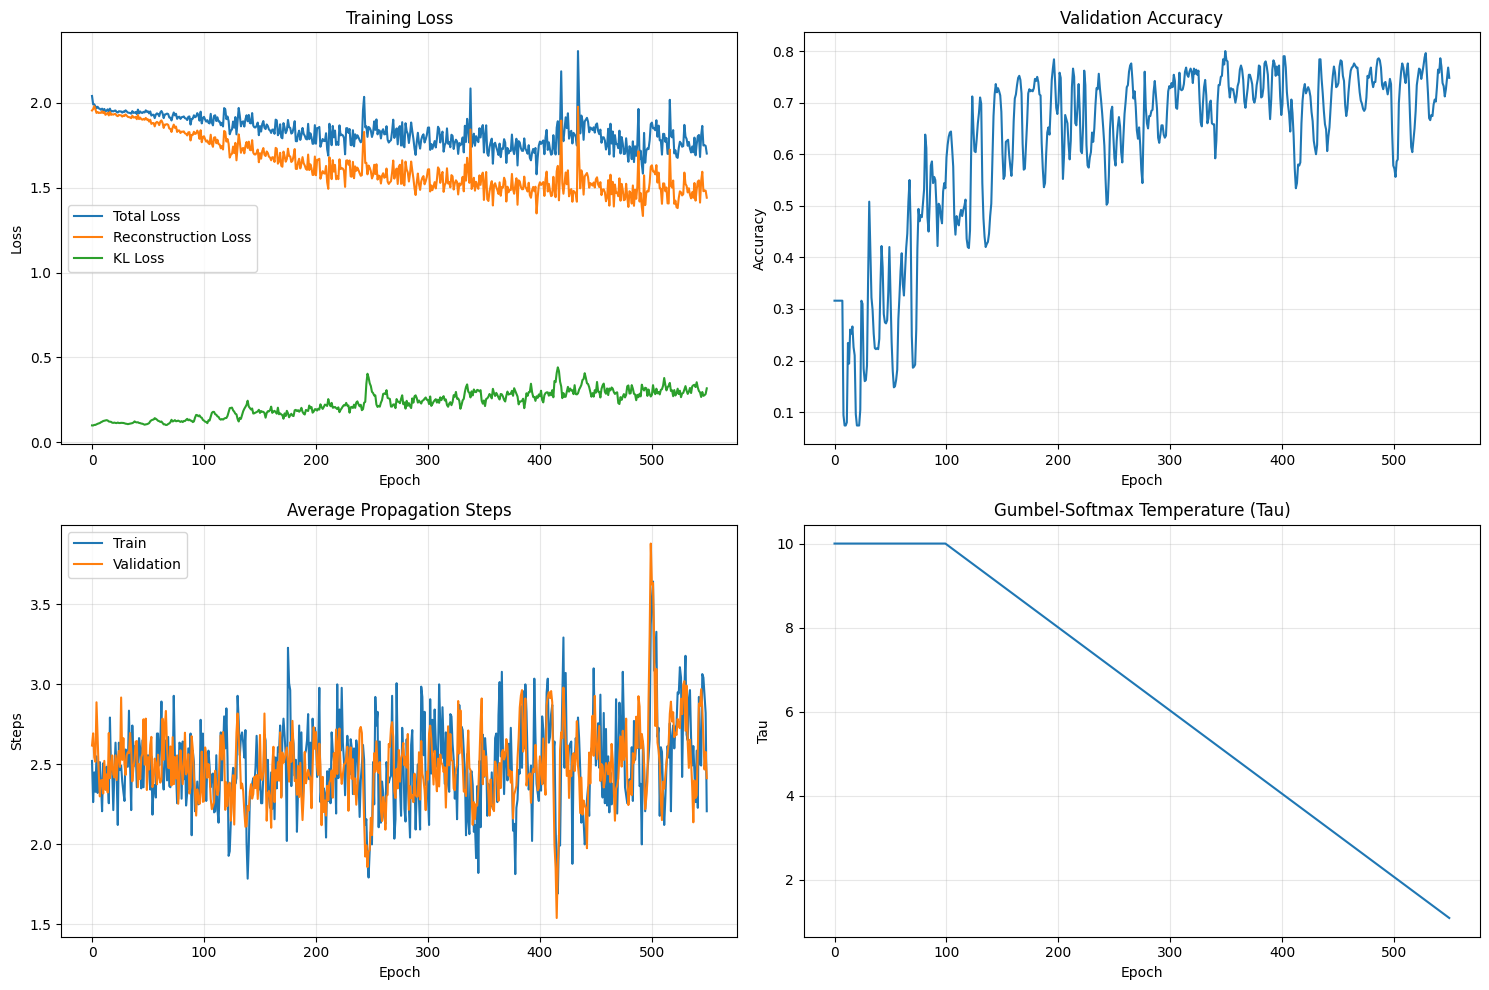

Training Set: Mean Step = 2.76, Std = 2.97
Validation Set: Mean Step = 2.73, Std = 2.76
Test Set: Mean Step = 2.62, Std = 2.72
Training Set (Expected): Mean = 3.82, Std = 0.80
Validation Set (Expected): Mean = 3.66, Std = 0.53
Test Set (Expected): Mean = 3.64, Std = 0.54


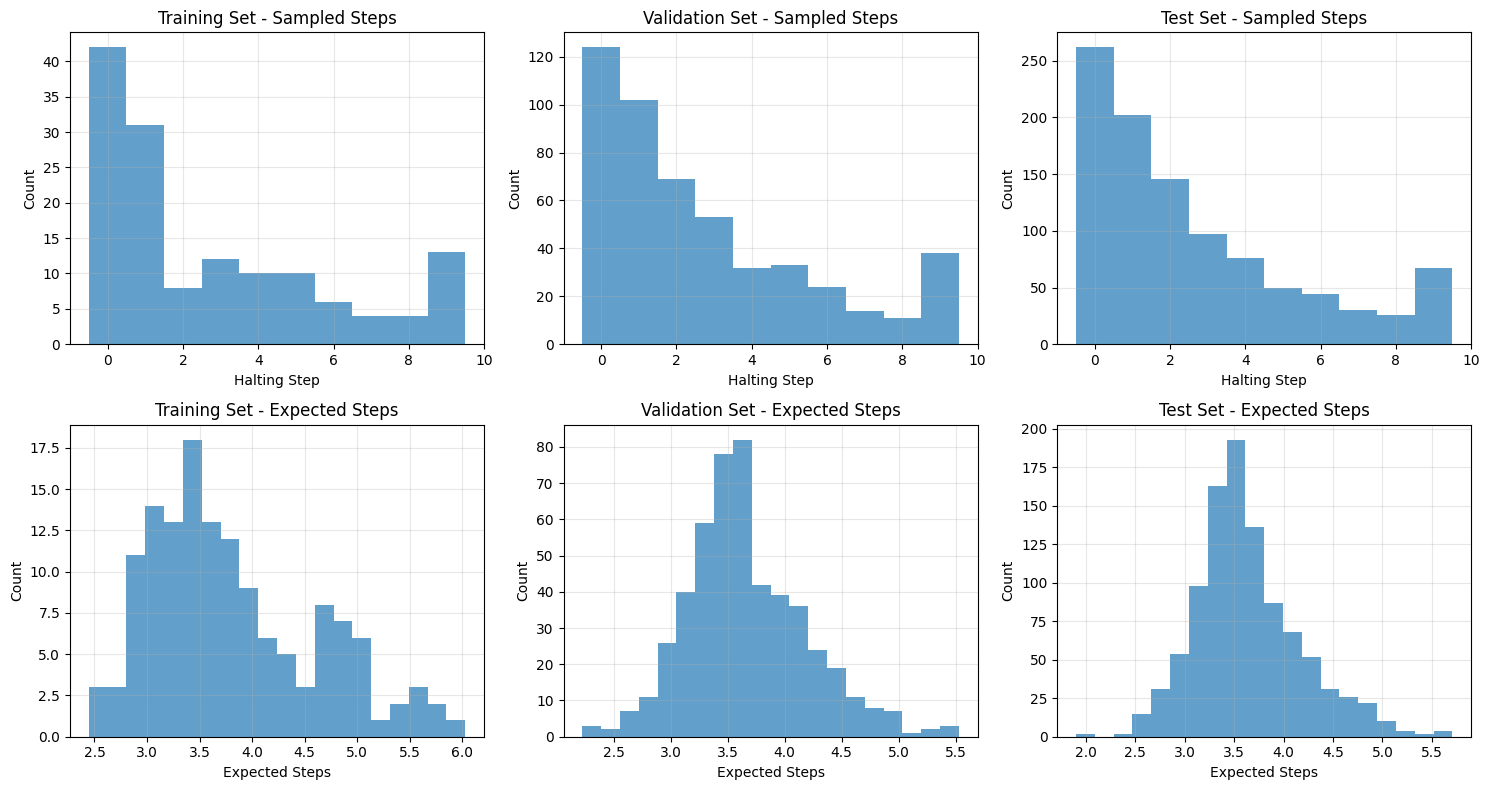

Class 0: Mean Steps = 2.60, Std = 2.62
Class 0 (Expected): Mean Steps = 3.83, Std = 0.29
Class 1: Mean Steps = 2.31, Std = 2.36
Class 1 (Expected): Mean Steps = 3.32, Std = 0.24
Class 2: Mean Steps = 2.15, Std = 2.41
Class 2 (Expected): Mean Steps = 3.04, Std = 0.32
Class 3: Mean Steps = 2.55, Std = 2.65
Class 3 (Expected): Mean Steps = 3.51, Std = 0.29
Class 4: Mean Steps = 2.69, Std = 2.69
Class 4 (Expected): Mean Steps = 3.58, Std = 0.30
Class 5: Mean Steps = 3.17, Std = 2.77
Class 5 (Expected): Mean Steps = 4.45, Std = 0.41
Class 6: Mean Steps = 3.56, Std = 3.40
Class 6 (Expected): Mean Steps = 4.50, Std = 0.47


<ipython-input-38-adb4f9c59064>:428: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(class_steps, labels=class_labels, patch_artist=True)


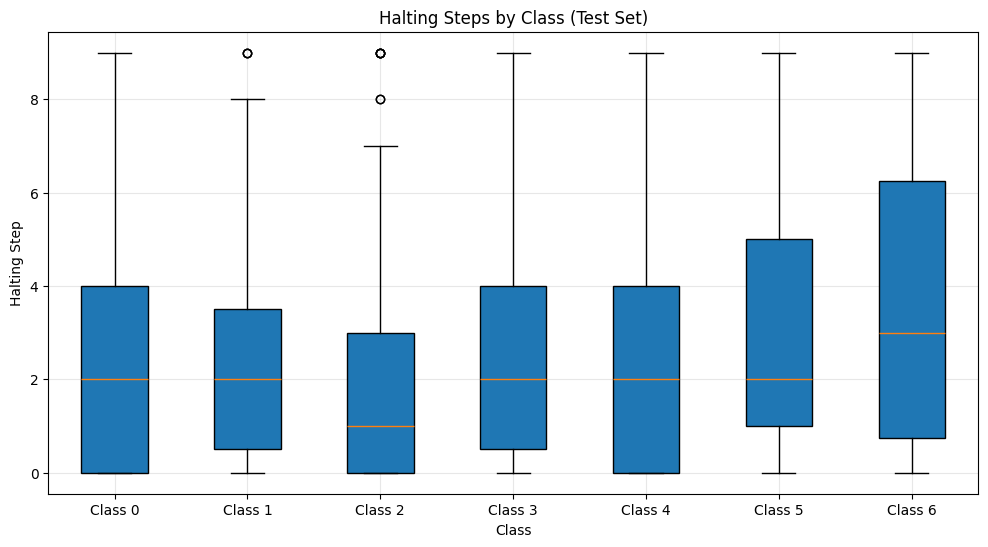

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch.nn import ModuleList, Dropout, ReLU, Linear
from torch_geometric.nn import MessagePassing
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import dropout_edge
from torch_geometric.nn.conv.gcn_conv import gcn_norm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time

# seeding
torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

config = {
    "dataset_name": "Cora",
    "mlp_hidden": [64],
    "dropout": 0.5,

    # propagation
    "niter": 10,
    "edge_dropout": 0.3,

    # Ponder settings
    "beta": 0,                  # KL regularization weight
    "lambda_p": 0.1,

    "learning_rate": 0.01,
    "weight_decay": 0.008,
    "num_epochs": 1000,
    "patience": 200,

    # Gumbel settings -> the idea of applying annealing is to embed more exploration at the beginning by adding more noise and then reducing it.
    "tau_initial": 10.0,            # Starting tau for Gumbel-softmax
    "tau_final": 0.1,              # Final tau
    "tau_warmup": 100,              # epochs before starting tau annealing
    "tau_decay": 500,              # epochs over which to decay tau
}

##############################################
# AP-GCN with Gumbel Sampling
##############################################
class SampleGumbel(nn.Module):
    def __init__(self, dataset, config):
        super(SampleGumbel, self).__init__()
        self.config = config
        self.niter = config["niter"]

        in_features = dataset.data.x.shape[1]
        hidden_dim = config["mlp_hidden"][0]
        out_features = dataset.num_classes

        # Local prediction network
        self.fc1 = Linear(in_features, hidden_dim)
        self.fc2 = Linear(hidden_dim, out_features)

        self.halt = Linear(out_features, 1)

        self.dropout = Dropout(p=config["dropout"])

        self.beta = config["beta"]
        self.lambda_p = config["lambda_p"]

        self.halt.bias.data.fill_(-1.0)
        self.training_steps = []

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Initial embedding
        h = F.relu(self.fc1(self.dropout(x)))
        h = self.fc2(self.dropout(h))


        predictions = [h] # predictions at each step

        # prop steps
        current_h = h
        halting_logits = []
        for _ in range(self.niter):
            if self.training and self.config["edge_dropout"] > 0:
                drop_edge_index, _ = dropout_edge(edge_index, p=self.config["edge_dropout"])
            else:
                drop_edge_index = edge_index

            edge_index_norm, norm = gcn_norm(
                drop_edge_index, None,
                x.size(0), False, True, "source_to_target", x.dtype
            )

            # mp
            row, col = edge_index_norm
            x_j = current_h[row] * norm.view(-1, 1)
            new_h = torch.zeros_like(current_h)
            new_h.scatter_add_(0, col.unsqueeze(1).expand(-1, current_h.size(1)), x_j)

            current_h = self.dropout(new_h)
            predictions.append(current_h)

            # halting logit
            logit = self.halt(current_h)
            halting_logits.append(logit)

        halting_logits = torch.cat(halting_logits, dim=1)
        lambda_vals = torch.sigmoid(halting_logits) # halting probabilities

        # halting distribution (PonderNet-style)
        p_list = []
        remaining_prob = torch.ones(lambda_vals.size(0), 1, device=lambda_vals.device)
        for n in range(self.niter):
            p_n = lambda_vals[:, n:n+1] * remaining_prob
            p_list.append(p_n)
            remaining_prob = remaining_prob * (1 - lambda_vals[:, n:n+1])

        p_list[-1] = p_list[-1] + remaining_prob
        p = torch.cat(p_list, dim=1)

        return predictions, p

    def compute_loss(self, predictions, p, target, tau):
        """Compute loss using Gumbel-softmax sample during training"""
        # sample a halting step using Gumbel-softmax
        log_p = torch.log(p + 1e-10)
        sampled = F.gumbel_softmax(log_p, tau=tau, hard=True)
        halt_steps = torch.argmax(sampled, dim=1)

        if self.training:
            self.training_steps.append(halt_steps.float().mean().item())

        # predictions at sampled steps
        selected_preds = torch.zeros_like(predictions[0])
        for n in range(self.niter):
            mask = (halt_steps == n)
            if mask.any():
                selected_preds[mask] = predictions[n+1][mask]

        # Cross-entropy loss on sampled predictions
        rec_loss = F.cross_entropy(selected_preds, target)

        # KL divergence with geometric prior
        n_steps = torch.arange(1, self.niter+1, device=p.device, dtype=torch.float)
        # Geometric distribution
        prior = self.lambda_p * (1 - self.lambda_p) ** (n_steps - 1)
        prior = prior / prior.sum()
        prior = prior.unsqueeze(0).expand(p.size(0), -1)

        # KL divergence
        kl_loss = torch.sum(p * (torch.log(p + 1e-10) - torch.log(prior + 1e-10)), dim=1).mean()

        total_loss = rec_loss + self.beta * kl_loss
        return total_loss, rec_loss, kl_loss, halt_steps

    def inference(self, data, tau=0.01):
        """Inference with controlled Gumbel sampling"""
        self.eval()
        with torch.no_grad():
            predictions, p = self.forward(data)

            # small tau for near-deterministic sampling
            log_p = torch.log(p + 1e-10)
            sampled = F.gumbel_softmax(log_p, tau=tau, hard=True)
            halt_steps = torch.argmax(sampled, dim=1)

            final_pred = torch.zeros_like(predictions[0])
            for n in range(self.niter):
                mask = (halt_steps == n)
                if mask.any():
                    final_pred[mask] = predictions[n+1][mask]

            return final_pred, halt_steps, p

def train(model, data, optimizer, epoch, config):
    model.train()

    # current temperature
    tau = get_tau(epoch, config)


    optimizer.zero_grad()
    predictions, p = model(data)

    train_mask = data.train_mask
    masked_preds = [pred[train_mask] for pred in predictions]
    masked_p = p[train_mask]
    masked_y = data.y[train_mask]

    # loss with Gumbel sampling
    loss, rec_loss, kl_loss, halt_steps = model.compute_loss(
        masked_preds, masked_p, masked_y, tau
    )

    # L2 regularization
    l2_reg = sum(torch.sum(param ** 2) for param in model.fc1.parameters())
    loss = loss + (config["weight_decay"] / 2) * l2_reg

    loss.backward()
    optimizer.step()

    avg_steps = halt_steps.float().mean().item()
    return loss.item(), rec_loss.item(), kl_loss.item(), avg_steps, tau

def evaluate(model, data, mask=None, tau=0.01):
    model.eval()

    if mask is None:
        mask = torch.ones(data.num_nodes, dtype=torch.bool, device=data.x.device)

    with torch.no_grad():
        final_pred, halt_steps, _ = model.inference(data, tau=tau)

        # Calculate accuracy
        pred = final_pred[mask].max(1)[1]
        correct = pred.eq(data.y[mask]).sum().item()
        total = mask.sum().item()
        accuracy = correct / total if total > 0 else 0

        # Average steps
        avg_steps = halt_steps[mask].float().mean().item()

    return accuracy, avg_steps, halt_steps[mask]

def get_tau(epoch, config):
    """tau value for current epoch"""
    warmup = config.get("tau_warmup", 0)
    decay = config.get("tau_decay", 200)
    tau_initial = config.get("tau_initial", 1.0)
    tau_final = config.get("tau_final", 0.1)

    if epoch <= warmup:
        return tau_initial

    if epoch >= warmup + decay:
        return tau_final

    # linear decay
    progress = (epoch - warmup) / decay
    tau = tau_initial - progress * (tau_initial - tau_final)

    return tau

def train_model(model, data, config):
    optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])

    best_val_acc = 0
    patience_counter = 0
    history = {
        'train_loss': [],
        'rec_loss': [],
        'kl_loss': [],
        'train_steps': [],
        'val_acc': [],
        'val_steps': []
    }

    print(f"Training model with Gumbel sampling...")

    for epoch in range(1, config["num_epochs"] + 1):
        loss, rec_loss, kl_loss, train_steps, tau = train(
            model, data, optimizer, epoch, config
        )

        # eval on validation set
        val_acc, val_steps, _ = evaluate(model, data, data.val_mask)

        history['train_loss'].append(loss)
        history['rec_loss'].append(rec_loss)
        history['kl_loss'].append(kl_loss)
        history['train_steps'].append(train_steps)
        history['val_acc'].append(val_acc)
        history['val_steps'].append(val_steps)

        if epoch % 10 == 0:
            print(f"Epoch {epoch:03d} (tau: {tau:.4f}): "
                  f"Loss: {loss:.4f} (Rec: {rec_loss:.4f}, KL: {kl_loss:.4f}), "
                  f"Steps: {train_steps:.2f}, Val Acc: {val_acc:.4f}, Val Steps: {val_steps:.2f}")


        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), f"best_model_{config['dataset_name']}.pt")
            print(f"--> Saving best model at epoch {epoch} with validation accuracy {val_acc:.4f}")
        else:
            patience_counter += 1

        if patience_counter >= config["patience"]:
            print(f"--> Early stopping at epoch {epoch}")
            break

    model.load_state_dict(torch.load(f"best_model_{config['dataset_name']}.pt"))
    return model, history

def visualize_training(history, config):
    """Visualize training history"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot loss
    axes[0, 0].plot(history['train_loss'], label='Total Loss')
    axes[0, 0].plot(history['rec_loss'], label='Reconstruction Loss')
    axes[0, 0].plot(history['kl_loss'], label='KL Loss')
    axes[0, 0].set_title('Training Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Plot validation accuracy
    axes[0, 1].plot(history['val_acc'])
    axes[0, 1].set_title('Validation Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].grid(True, alpha=0.3)

    # Plot propagation steps
    axes[1, 0].plot(history['train_steps'], label='Train')
    axes[1, 0].plot(history['val_steps'], label='Validation')
    axes[1, 0].set_title('Average Propagation Steps')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Steps')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Plot tau schedule
    tau_values = [get_tau(epoch, config) for epoch in range(1, len(history['train_loss'])+1)]
    axes[1, 1].plot(tau_values)
    axes[1, 1].set_title('Gumbel-Softmax Temperature (Tau)')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Tau')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"training_history_{config['dataset_name']}.png", dpi=300)
    plt.show()

def visualize_halt_steps(model, data, config):
    """halting step distribution"""
    model.eval()

    with torch.no_grad():
        # predictions with inference tau
        _, halt_steps, p = model.inference(data, tau=0.01)

        # Expected steps based on halting distribution
        expected_steps = torch.sum(
            p * torch.arange(1, model.niter+1, device=p.device).unsqueeze(0), dim=1
        )

        # Extract steps for different sets
        train_steps = halt_steps[data.train_mask].cpu().numpy()
        val_steps = halt_steps[data.val_mask].cpu().numpy()
        test_steps = halt_steps[data.test_mask].cpu().numpy()

        train_exp = expected_steps[data.train_mask].cpu().numpy()
        val_exp = expected_steps[data.val_mask].cpu().numpy()
        test_exp = expected_steps[data.test_mask].cpu().numpy()

        # Create figure
        fig, axes = plt.subplots(2, 3, figsize=(15, 8))

        # actual steps
        for i, (steps, title) in enumerate(zip(
            [train_steps, val_steps, test_steps],
            ['Training Set', 'Validation Set', 'Test Set']
        )):
            axes[0, i].hist(steps, bins=np.arange(-0.5, model.niter + 0.5), alpha=0.7)
            axes[0, i].set_title(f'{title} - Sampled Steps')
            axes[0, i].set_xlabel('Halting Step')
            axes[0, i].set_ylabel('Count')
            axes[0, i].grid(True, alpha=0.3)

            print(f"{title}: Mean Step = {np.mean(steps):.2f}, Std = {np.std(steps):.2f}")

        # expected steps
        for i, (steps, title) in enumerate(zip(
            [train_exp, val_exp, test_exp],
            ['Training Set', 'Validation Set', 'Test Set']
        )):
            axes[1, i].hist(steps, bins=20, alpha=0.7)
            axes[1, i].set_title(f'{title} - Expected Steps')
            axes[1, i].set_xlabel('Expected Steps')
            axes[1, i].set_ylabel('Count')
            axes[1, i].grid(True, alpha=0.3)

            print(f"{title} (Expected): Mean = {np.mean(steps):.2f}, Std = {np.std(steps):.2f}")

        plt.tight_layout()
        plt.savefig(f"halt_step_distribution_{config['dataset_name']}.png", dpi=300)
        plt.show()

def analyze_by_class(model, data):
    """halting behavior by class"""
    model.eval()

    with torch.no_grad():
        _, halt_steps, p = model.inference(data, tau=0.01)
        expected_steps = torch.sum(
            p * torch.arange(1, model.niter+1, device=p.device).unsqueeze(0), dim=1
        )

        num_classes = int(data.y.max().item() + 1)
        plt.figure(figsize=(12, 6))

        class_steps = []
        class_labels = []

        for c in range(num_classes):
            # test nodes of this class
            class_mask = data.test_mask & (data.y == c)
            if class_mask.sum() > 0:
                steps = halt_steps[class_mask].cpu().numpy()
                exp_steps = expected_steps[class_mask].cpu().numpy()

                print(f"Class {c}: Mean Steps = {np.mean(steps):.2f}, Std = {np.std(steps):.2f}")
                print(f"Class {c} (Expected): Mean Steps = {np.mean(exp_steps):.2f}, Std = {np.std(exp_steps):.2f}")

                class_steps.append(steps)
                class_labels.append(f"Class {c}")

        # boxplot
        plt.boxplot(class_steps, labels=class_labels, patch_artist=True)
        plt.title('Halting Steps by Class (Test Set)')
        plt.xlabel('Class')
        plt.ylabel('Halting Step')
        plt.grid(True, alpha=0.3)
        plt.savefig(f"steps_by_class_{config['dataset_name']}.png", dpi=300)
        plt.show()

def main(config):
    """Main function"""
    print(f"Loading {config['dataset_name']} dataset...")
    dataset = Planetoid(
        root=f'./data/{config["dataset_name"]}',
        name=config["dataset_name"],
        transform=T.NormalizeFeatures()
    )
    data = dataset[0].to(device)

    # dataset info
    print(f"Dataset details:")
    print(f"  - Number of nodes: {data.num_nodes}")
    print(f"  - Number of edges: {data.num_edges}")
    print(f"  - Number of features: {data.num_features}")
    print(f"  - Number of classes: {dataset.num_classes}")
    print(f"  - Number of training nodes: {data.train_mask.sum().item()}")
    print(f"  - Number of validation nodes: {data.val_mask.sum().item()}")
    print(f"  - Number of test nodes: {data.test_mask.sum().item()}")


    model = SampleGumbel(dataset, config).to(device)
    model, history = train_model(model, data, config)

    # test set
    test_acc, test_steps, _ = evaluate(model, data, data.test_mask)
    print(f"\nTest Results:")
    print(f"  Accuracy: {test_acc:.4f}")
    print(f"  Average Steps: {test_steps:.2f}")

    # visualization
    visualize_training(history, config)
    visualize_halt_steps(model, data, config)
    analyze_by_class(model, data)

    return model, data

if __name__ == "__main__":
    model, data = main(config)